In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import torchvision
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import (
    Variable,
)
from torch.nn import (
    init,
)
from torchvision import (
    datasets, 
    transforms,
    models,
    utils,
)

%matplotlib inline

In [4]:
# training params
model_name = 'resnet18'
num_workers = 4
num_epochs = 30
batch_size = 16
learning_rate = 0.01
momentum = 0.9
weight_decay = 1e-4
log_every = 10
dropout_p = 0.4
decay_rate = 0.9999
max_grad_norm = 5.0
log_interval = 1
num_classes = 8

# reproduceability
seed = 42
torch.manual_seed(seed)

In [5]:
image_folder = 'data/'
data_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.47637546, 0.485785  , 0.4522678 ], [0.24692202, 0.24377407, 0.2667196 ])
    ])
data = datasets.ImageFolder(root=image_folder, transform=data_transforms)
class_names = data.classes
train_len, val_len = int(len(data) * 0.75), int(len(data) * 0.2)
test_len = len(data) - train_len - val_len
train_set, val_set, test_set = torch.utils.data.random_split(data, [train_len, val_len, test_len])
loader = {
    'train': torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4),
    'test': torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=4)
}

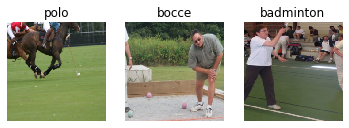

In [6]:
batch = next(iter(loader['train']))
samples = batch[0][:3]
y_true = batch[1]
for i, sample in enumerate(samples):
    plt.subplot(1, 3, i+1)
    plt.title(f'{class_names[y_true[i]]}')
    inp = sample.numpy().transpose((1, 2, 0))
    mean = np.array([0.47637546, 0.485785  , 0.4522678 ])
    std = np.array([0.24692202, 0.24377407, 0.2667196 ])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis('off')

In [7]:
model = models.__dict__[model_name](pretrained=False) # Set false to train from scratch
# Alter the final layer
final_layer_input = model.fc.in_features
model.fc = nn.Linear(final_layer_input, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=learning_rate, 
                      momentum=momentum, 
                      weight_decay=weight_decay,
                     )
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
def process_batch(inputs, targets, model, criterion, optimizer, is_training):
    """
    Process a minibatch for loss and accuracy.
    """
    
    # Convert tensors to Variables (for autograd)
    if is_training:
        X_batch = Variable(inputs, requires_grad=False)
    else:
        X_batch = Variable(inputs, volatile=True, requires_grad=False)
    y_batch = Variable(targets.long(), requires_grad=False)

    # Forward pass
    scores = model(X_batch) # logits

    # Loss
    loss = criterion(scores, y_batch)
    
    # Accuracy
    score, predicted = torch.max(scores, 1)
    accuracy = (y_batch.data == predicted.data).sum() / float(len(y_batch))
    
    if is_training:

        # Use autograd to do backprop. This will compute the
        # gradients w.r.t loss for all Variables that have
        # requires_grad=True. So, our w1 and w2 will now have
        # gradient components we can access.
        optimizer.zero_grad()
        loss.backward()
        
        # Clip the gradient norms
        nn.utils.clip_grad_norm(model.parameters(), max_grad_norm)

        # Update params
        optimizer.step()

    return loss, accuracy

In [9]:
def train(model, criterion, optimizer, train_loader, test_loader, 
          num_epochs, batch_size, log_interval, learning_rate,
          dropout_p, decay_rate, max_grad_norm):
    """
    Training.
    """
    
    # Metrics
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    # Training
    for num_train_epoch in range(num_epochs):

        # Timer
        start = time.time()

        # Decay learning rate
        learning_rate = learning_rate * (decay_rate ** (num_train_epoch // 1.0))
        for param_group in optimizer.param_groups:
            param_group['lr'] = learning_rate

        # Metrics
        train_batch_loss = 0.0
        train_batch_accuracy = 0.0

        for train_batch_num, (inputs, target) in enumerate(train_loader):

            # Get metrics
            model.train()
            loss, accuracy = process_batch(inputs, target, model, criterion, optimizer, model.training)
            #print(loss.data.item())
            # Add to batch scalars
            train_batch_loss += loss.data.item() / float(len(inputs))
            train_batch_accuracy += accuracy
            
        # Add to global metrics
        train_loss.append(train_batch_loss/float(train_batch_num+1))
        train_acc.append(train_batch_accuracy/float(train_batch_num+1))

        # Testing
        model.eval()
        for num_test_epoch in range(1):

            # Metrics
            test_batch_loss = 0.0
            test_batch_accuracy = 0.0

            for test_batch_num, (inputs, target) in enumerate(test_loader):

                # Get metrics
                model.eval()
                loss, accuracy = \
                    process_batch(inputs, target, model, criterion, optimizer, model.training)
                # Add to batch scalars
                test_batch_loss += loss.data.item() / float(len(inputs))
                test_batch_accuracy += accuracy

            # Add to global metrics
            test_loss.append(test_batch_loss/float(test_batch_num+1))
            test_acc.append(test_batch_accuracy/float(test_batch_num+1))
                

            verbose_condition = \
                (num_train_epoch == 0) or (num_train_epoch % log_interval == 0) or (num_train_epoch == num_epochs-1)

            # Verbose
            if verbose_condition:

                # Verbose
                time_remain = (time.time() - start) * (num_epochs - (num_train_epoch+1))
                minutes = time_remain // 60
                seconds = time_remain - minutes*60
                print("TIME REMAINING: %im %is" % (minutes, seconds))
                print("[EPOCH]: %i, [TRAIN LOSS]: %.6f, [TRAIN ACC]: %.3f, [TEST LOSS]: %.6f, [TEST ACC]: %.3f" %
                       (num_train_epoch, train_batch_loss/float(train_batch_num+1), 
                        train_batch_accuracy/float(train_batch_num+1), test_batch_loss/float(test_batch_num+1),
                        test_batch_accuracy/float(test_batch_num+1)))
    
    return model

In [10]:
model = train(model, criterion, optimizer, loader['train'], loader['val'], 
              num_epochs, batch_size, log_interval, learning_rate,
              dropout_p, decay_rate, max_grad_norm)

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # Remove the CWD from sys.path while we load stuff.


TIME REMAINING: 28m 37s
[EPOCH]: 0, [TRAIN LOSS]: 0.126198, [TRAIN ACC]: 0.250, [TEST LOSS]: 0.122366, [TEST ACC]: 0.312
TIME REMAINING: 22m 2s
[EPOCH]: 1, [TRAIN LOSS]: 0.117617, [TRAIN ACC]: 0.367, [TEST LOSS]: 0.107783, [TEST ACC]: 0.460
TIME REMAINING: 21m 34s
[EPOCH]: 2, [TRAIN LOSS]: 0.110679, [TRAIN ACC]: 0.421, [TEST LOSS]: 0.118826, [TEST ACC]: 0.422
TIME REMAINING: 21m 48s
[EPOCH]: 3, [TRAIN LOSS]: 0.092675, [TRAIN ACC]: 0.512, [TEST LOSS]: 0.137762, [TEST ACC]: 0.464
TIME REMAINING: 19m 58s
[EPOCH]: 4, [TRAIN LOSS]: 0.087847, [TRAIN ACC]: 0.552, [TEST LOSS]: 0.129956, [TEST ACC]: 0.490
TIME REMAINING: 19m 6s
[EPOCH]: 5, [TRAIN LOSS]: 0.083165, [TRAIN ACC]: 0.568, [TEST LOSS]: 0.113271, [TEST ACC]: 0.482
TIME REMAINING: 17m 46s
[EPOCH]: 6, [TRAIN LOSS]: 0.086637, [TRAIN ACC]: 0.553, [TEST LOSS]: 0.103312, [TEST ACC]: 0.506
TIME REMAINING: 18m 30s
[EPOCH]: 7, [TRAIN LOSS]: 0.077942, [TRAIN ACC]: 0.602, [TEST LOSS]: 0.096051, [TEST ACC]: 0.537
TIME REMAINING: 16m 48s
[EPOCH]: 8

In [11]:
def infer(model, inputs):
    """
    Inference.
    """
    # Convert tensors to Variables (for autograd)
    X_batch = Variable(inputs, volatile=True, requires_grad=False)

    # Forward pass
    scores = model(X_batch)  # logits

    # Accuracy
    score, predicted = torch.max(scores, 1)

    return predicted

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


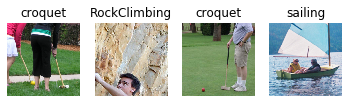

In [14]:
# Visualize some predictions
batch = next(iter(loader['test']))
samples = batch[0][:4]
y_preds = infer(model, samples)
for i, sample in enumerate(samples):
    plt.subplot(1, 4, i+1)
    plt.title(f'{class_names[y_preds[i]]}')
    inp = sample.numpy().transpose((1, 2, 0))
    mean = np.array([0.47637546, 0.485785  , 0.4522678 ])
    std = np.array([0.24692202, 0.24377407, 0.2667196 ])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis('off')

In [26]:
dummy_input = torch.randn(4, 3, 224, 224)
torch.onnx.export(model, dummy_input, "sports_classification-scratch.onnx")

In [27]:
import onnxruntime as ort

ort_session = ort.InferenceSession('sports_classification-scratch.onnx')

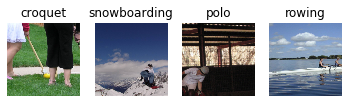

In [33]:
# Visualize onnx predictions
batch = next(iter(loader['test']))
samples = batch[0][:4]
outputs = np.argmax(ort_session.run(None, {'input.1': samples.numpy()})[0], axis=1)
for i, sample in enumerate(samples):
    plt.subplot(1, 4, i+1)
    plt.title(f'{class_names[outputs[i]]}')
    inp = sample.numpy().transpose((1, 2, 0))
    mean = np.array([0.47637546, 0.485785  , 0.4522678 ])
    std = np.array([0.24692202, 0.24377407, 0.2667196 ])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis('off')